In [3]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
from measurement_model import measurement_model
from precip_model import precip_model
from GLD_file_tools import GLD_file_tools
from coordinate_structure import transform_coords
import datetime as dt

p = precip_model(database="database_dicts.pkl",multiple_bands = False)
gld = GLD_file_tools('GLD_mount',prefix='GLD')

td = dt.timedelta(seconds = 10)

# Output grid space:
out_lat_grid = np.arange(-90, 89, step=1)
out_lon_grid = np.arange(-180,179,step=1)

out_grid = np.meshgrid(out_lat_grid, out_lon_grid)

print np.shape(out_grid)

T_STEP = p.db[p.db.keys()[0]]['RES_DT']
T_MAX  = p.db[p.db.keys()[0]]['RES_FINT']
NUM_STEPS = np.round(T_MAX/T_STEP)


in_time_str = "2015-11-01T12:45:00"
in_time = dt.datetime.strptime(in_time_str,  "%Y-%m-%dT%H:%M:%S")

time_sampling_vector = np.linspace(-T_MAX,0,NUM_STEPS)

lat_ind = 7
lon_ind = 8
mag_ind = 9

flashes, flash_times = gld.load_flashes(in_time, td)
if flashes is None:
    print "No flashes found at ", in_time
else:
    print np.shape(flashes)

flashes = flashes[:,(lat_ind, lon_ind, mag_ind, mag_ind)]
flash_coords = transform_coords(flashes[:,0], flashes[:,1], np.zeros_like(flashes[:,0]), 'geographic', 'geomagnetic')
flashes[:,:2] = flash_coords[:,:2]
flashes[:,3] = [(in_time - s).microseconds*1e-6 + (in_time - s).seconds for s in flash_times]


# Mask out flashes outside the range of the interpolator:
mask = (  (np.abs(flashes[:,0]) > 10) 
        & (np.abs(flashes[:,0]) < 60)) 
        # (flashes[:,2] > 50))

# Mask out flashes not of interest to the satellite:
# atten_factors = longitude_scaling(flash_coords, sat.coords)
# mask = atten_factors < 24

print "%g flashes (post-filter)" % np.sum(mask)

masked_flashes = flashes[mask, :]    
    
    


# flux = 0
flux = np.zeros(np.shape(out_grid)[1:])
# for lati, lat in enumerate(out_lat_grid):
#     for loni, lon in enumerate(out_lon_grid):
# for f in flashes:
    #print td.seconds - f[3]   
#     flux += np.sum( p.get_precip_at(f[0], lat, time_sampling_vector + f[3]) *
#                       p.get_longitude_scaling(f[0], f[1], lon, I0=f[2]) * T_STEP )

in_lat = 40
in_lon = 0
in_del = 10
lat_vec = np.zeros_like(out_lat_grid)

for f in masked_flashes:
    # Get interpolated lat grid 
    for lati, lat in enumerate(out_lat_grid):
        lat_vec[lati] = np.sum(p.get_precip_at(f[0], lat, time_sampling_vector + f[3]))

    lon_vec = p.get_longitude_scaling(f[0],f[1], out_lon_grid, I0 = f[2])
    flux += np.outer(lon_vec, lat_vec)

    
print "max flux:", np.max(flux)
    

In [ ]:
# T_STEP = p.db[p.db.keys()[0]]['RES_DT']
# T_MAX  = p.db[p.db.keys()[0]]['RES_FINT']
# print RES_DT
# print T_MAX

plt.figure()
plt.imshow(np.log10(flux.T))


In [ ]:
tt=30

tmask = (masked_flashes[:,3] + grid_time[tt] > 0 ) & (masked_flashes[:,3] + grid_time[tt] < 1)
print masked_flashes[tmask,3]
plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
plt.clim([-12,0])
plt.pcolor(grid_lons, -1*np.flipud(grid_lats), np.fliplr(np.log10(S_grid[:,:,tt])).T)
plt.clim([-12,0])
plt.colorbar()
plt.scatter(masked_flashes[tmask,1], masked_flashes[tmask,0],marker='.')
plt.scatter(sat.coords.lon(), sat.coords.lat(),marker='x',color='red')
#plt.scatter(masked_coords.lon(), masked_coords.lat())
#plt.clim([-12,0])
plt.show() 

# for tt in grid_time:
#     plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
#     plt.clim([-8,4])
#     plt.show()

In [2]:
from build_database import build_database
from load_sim_constants import load_sim_constants
from load_phi_files import load_phi_files

old_dir = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv3/outputs/probably/run_sat/'

# sc = load_sim_constants(os.path.join(old_dir,'codesrc/consts.h'),old_format=True)

# N, S, L = load_phi_files(old_dir + "in_45", sc)

# print "max N:", np.max(N)
# print "min N:", np.min(N)

# print np.shape(N)

build_database(input_dir = old_dir, output_filename = "db_test2.pkl",old_format = True, t_new_step=0.5, num_L = 33)



succeeded:  sc.PI = 3.14159265358979311599796346854418516159
failed: sc.D2R = PI/180.0
failed: sc.R2D = 180.0/PI
succeeded:  sc.Q_EL = 1.602E-19
succeeded:  sc.M_EL = 9.1E-31
succeeded:  sc.E_EL = 5.105396765648739E5
failed: sc.MU0 = PI*4E-7
succeeded:  sc.EPS0 = 8.854E-12
succeeded:  sc.C = 2.997956376932163e+08
succeeded:  sc.Z0 = 377.0
succeeded:  sc.R_E = 6370000.0
succeeded:  sc.H_MAGNETO = 1E6
succeeded:  sc.H_IONO = 1E5
succeeded:  sc.A = 5E3
succeeded:  sc.B = 1E5
succeeded:  sc.H_E = 5000.0
succeeded:  sc.P_DIST = 0.0
succeeded:  sc.Q_DIST = 2.0
succeeded:  sc.AN_CM_DIST = 2E5
succeeded:  sc.V0_DIST = 1.0
succeeded:  sc.M_RES = 0
succeeded:  sc.E_MIN = 10E3
succeeded:  sc.E_MAX = 5E6
succeeded:  sc.NUM_E = 8
succeeded:  sc.SQUARE = 1
failed: sc.E_EXP_BOT = log10(E_MIN)
failed: sc.E_EXP_TOP = log10(E_MAX)
failed: sc.DE_EXP = ((E_EXP_TOP
succeeded:  sc.EALimS = -40.0
succeeded:  sc.EALimN = 40.0
succeeded:  sc.EAIncr = 1.0
succeeded:  sc.dL0 = 6E-4
succeeded:  sc.DF = 50.0
succ

In [2]:
import pickle

with open("db_test2.pkl",'r') as file:
    deebee = pickle.load(file)
file.close()    
print deebee['in_lats']
print dir(deebee['consts'])
print dir(deebee)

print os.getcwd()
# clims = [-3,2]
# for il_ind, il_val in enumerate(db['in_lats']):
#     data = db['N_el'][il_ind,:,:]
#     print "N ranges: ",np.min(data), np.max(data)
#     plt.figure()
    
#     Nv = np.log10(data)
#     Nv = np.clip(Nv,clims[0],clims[1])
#     plt.imshow(Nv,origin='lower',interpolation='none')
#     plt.clim(clims)
#     plt.ylabel(il_val)





[10 15 20 25 30 35 40 45 50 55 60 65]
['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__']
['__class__', '__cmp__', '__contains__', '__delattr__', '__delitem__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'has_key', 'items', 'iteritems', 'iterkeys', 'itervalues', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values', 'viewitems', 'viewkeys', 'viewvalues']
/Users/austin/FUSE/shared/users/asousa/WIPP/global_precip


In [ ]:
with open("db_test.pkl",'rb') as file:
    db = pickle.load(file)

print db.keys()
sc = db['consts']
print dir(sc)



In [ ]:
# Let's downsample the things!


new_step = 0.5  # seconds
t = db[in_lats[0]]['t']


t_new = np.arange(0,T_MAX, step=new_step) # New time vector
intervals = np.round(t_new*NUM_STEPS/T_MAX).astype(int) # Intervals to sum between

# print t[intervals]
# t = db[in_lats[0]]['t']


in_tmp = N_arr[3,:,:]
out_tmp= np.zeros([len(in_lats),len(L_vec), len(t_new)])

for ind, Tp in enumerate(zip(intervals[0:], intervals[1:])):
    print ind, Tp
    out_tmp[3,:,ind] = np.sum(N_arr[3,:,Tp[0]:Tp[1]],axis=1)

plt.imshow(np.log10(out_tmp[3,:,:]))

(7, 320, 90)


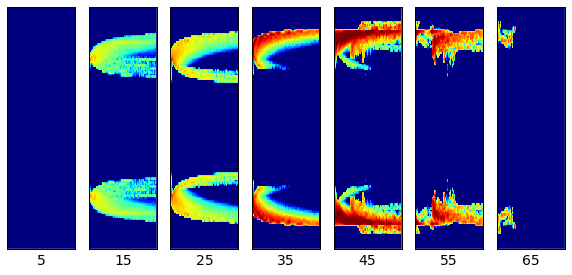

In [5]:
# Plot typical data from the precipitation model:
# time x out_lat,   1 plot per in_lat

from precip_model import precip_model

p = precip_model(database="db3.pkl", cumsum=False)

lat_targ = np.arange(-80,80,step=0.5)
in_lat_targ = np.arange(5,75,step=10)
num_inlats = len(in_lat_targ)
t = p.t

clims = [-3,4]

interp_d = p.get_multiple_precip_at(in_lat_targ, lat_targ, t)
print np.shape(interp_d)

fig = plt.figure()
ax = []
for i,lat in enumerate(in_lat_targ):
    ax.append(fig.add_subplot(1,num_inlats,i+1))
    #Nv = np.log10(interp_d[i,:,2:] - interp_d[i,:,0:-2])
    Nv = np.log10(interp_d[i,:,:])


    Nv = np.clip(Nv,clims[0],clims[1])
    pl = plt.imshow(Nv,origin='lower',interpolation='none')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel(lat)
    plt.clim(clims)


1.09350949866
0.0


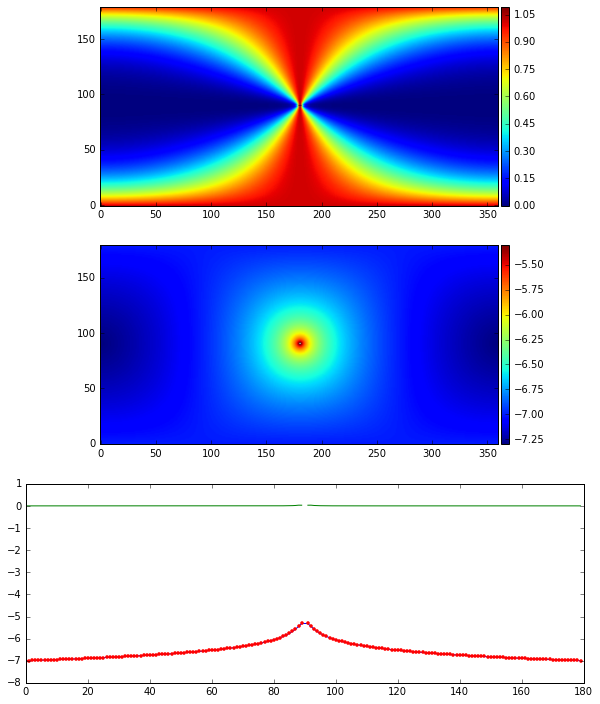

In [36]:
# Test scaling factor:
from mpl_toolkits.axes_grid1 import make_axes_locatable


from precip_model import precip_model
p = precip_model(database="db3.pkl")

inp_lat = 0
inp_lon = 0
out_lat = np.arange(-90,90)
out_lon = np.arange(-180,180)

# D2R = np.pi/180.0
# R_E = 6378.0
# dlat  = D2R*(out_lat - inp_lat)
# dlong = D2R*(out_lon - inp_lon)
# clat1 = np.cos(D2R*inp_lat)
# clat2 = np.cos(D2R*out_lat)
# slat1 = np.sin(D2R*inp_lat)
# slat2 = np.sin(D2R*out_lat)

# # Vincenty solution (spherical)
# # a = np.outer(clat2, np.sin(dlong))
# # b = clat1*slat2[:,np.newaxis] - np.outer(slat1*clat2, np.cos(dlong))
# # c = slat1*slat2[:,np.newaxis] + np.outer(clat1*clat2, np.cos(dlong))

# # D = 6378*np.arctan2( np.sqrt(pow(a,2) + pow(b,2)), c)

# # Haversine formula:
# a = pow(np.sin(dlat/2.0),2)
# b = (clat1*np.outer(clat2, pow(np.sin(dlong/2.0),2)))

# D = 2.0*R_E * np.arcsin(np.sqrt(a[:,np.newaxis] + b))

ratio, new_weight, old_weight = p.get_longitude_scaling(inp_lat, inp_lon, out_lat, out_lon, I0=-100000)

print np.max(ratio)
print np.min(ratio)

fig = plt.figure()
ax1 = fig.add_subplot(311)
p1 = ax1.imshow((ratio),origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(p1, cax=cax)

ax2 = fig.add_subplot(312)
p2 = ax2.imshow(np.log10(new_weight),origin='lower')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(p2, cax=cax2)


ax3 = fig.add_subplot(313)

p3 = ax3.plot(np.log10(old_weight))
p4 = ax3.plot(np.log10(new_weight[:,180]),'r.')
p5 = ax3.plot(np.log10(ratio[:,180]))


In [ ]:
# Load flashes, calculate total precipitation (el/(cm^2)) within a time window:
import numpy as np
from GLD_file_tools import GLD_file_tools
from precip_model import precip_model
from calc_global_precip import calc_global_precip


# Instantiate objects:
p = precip_model(database="db_test.pkl", cumsum=True)
gld = GLD_file_tools('GLD_mount',prefix='GLD')

in_lat_grid  = np.arange(-70,70, step=0.1)
out_lat_grid = np.arange(-90,90,step=0.5)
out_lon_grid = np.arange(-180,180,step=0.5)
# out_grid = np.meshgrid(out_lat_grid, out_lon_grid)

# precip_map = np.zeros_like(out_grid)

in_time_str = "2015-11-01T10:45:00"
in_time = dt.datetime.strptime(in_time_str,  "%Y-%m-%dT%H:%M:%S")

# flux = calc_global_precip(p, gld, in_time, 1, out_lat_grid, out_lon_grid)
print np.shape(in_lat_grid)
print np.shape(out_lat_grid)
print np.shape(p.t)

p.precalculate_gridded_values(in_lat_grid, out_lat_grid, p.t)




In [ ]:
lat_ind = 7
lon_ind = 8
mag_ind = 9
# How far back to load flashes from:
td = dt.timedelta(seconds=30)

print "Loading flashes..."

flashes, flash_times = gld.load_flashes(in_time, td)

# print flash_times
if flashes is None:
    print "No flashes found at ", in_time
else:
    print np.shape(flashes)

flashes = flashes[:,(lat_ind, lon_ind, mag_ind, mag_ind)]
flash_coords = transform_coords(flashes[:,0], flashes[:,1], np.zeros_like(flashes[:,0]), 'geographic', 'geomagnetic')
flashes[:,:2] = flash_coords[:,:2]
flashes[:,3] = [(in_time - s).microseconds*1e-6 + (in_time - s).seconds for s in flash_times]


# Mask out flashes outside the range of the interpolator:
mask = (  (np.abs(flashes[:,0]) > 10) 
        & (np.abs(flashes[:,0]) < 60)) 

print "%g flashes (post-filter)" % np.sum(mask)

masked_flashes = flashes[mask, :]


print "Getting grid indexes"

def nearest_index(grid, values):
    # Find closest index of a value in an array (i.e., quick quantize to grid value)
    idx = np.searchsorted(grid, values, side="left")
    idx = np.clip(idx, 0, len(grid) - 1)
    idx_l = np.clip(idx - 1, 0, len(grid) - 1)
    idx[abs(values - grid[idx_l]) < abs(values - grid[idx])] -= 1
    return idx


in_lat_inds  = nearest_index(p.pc_in_lats,  masked_flashes[:,0])
t_end_inds   = nearest_index(p.pc_t,masked_flashes[:,3])
t_start_inds = nearest_index(p.pc_t, masked_flashes[:,3] - 1.0)

# (num_flashes x num_outlats)
lv = (p.precalculated[in_lat_inds, : , t_end_inds] - p.precalculated[in_lat_inds, : , t_start_inds])

flux = np.zeros([len(out_lat_grid), len(out_lon_grid)])

for ind, f in enumerate(masked_flashes):
    scalefactor, _, _ = p.get_longitude_scaling(f[0], f[1], out_lat_grid, out_lon_grid, I0 = f[2])
    lv_single = lv[ind,:].squeeze()
    scalefactor*lv_single[:,np.newaxis]



In [1]:
print "flux ranges: ",np.min(flux),np.max(flux)

fig = plt.figure()
ax1 = fig.add_subplot(111)
# p1 = ax1.imshow(flux,origin='lower')
p1 = ax1.pcolor(out_lon_grid, out_lat_grid, flux)
# p1.set_clim([-10,-4])
plt.colorbar(p1)
p2 = ax1.scatter(masked_flashes[:,1],masked_flashes[:,0],marker='x',color='red')


flux ranges: 

NameError: name 'np' is not defined

In [ ]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out


tmp = cartesian([[1,2,3],[4,5,6],[7,8,9,10]])
print tmp